# NCAR Research Data Archive (RDA) Data:  Local Access Options

Most, or perhaps all, of data from the RDA is available on NCAR's local file storage systems.

For users with access to NCAR compute servers and storage, there are two repositories available:

*  Glade, a high-speed disk
*  Stratus, an object store

We will go over detailed examples for both cases below, using an example with surface wind data.

### Use Case:   Wind Farm Productivity Analysis

Suppose someone wants to know the potential amount of electricity that could be generated from a wind farm near Cheyenne, Wyoming.   This means knowing something about the wind speeds in the area, which could vary with the seasons. We might be interested in looking at wind speeds over a single season, or wind speeds over several consecutive years.   In this notebook, we will demonstrate how to do both.

The RDA Thredds Data Server has this dataset with surface wind observational data: [ERA5 Reanalysis (0.25 Degree Latitude-Longitude Grid)](https://rda.ucar.edu/datasets/ds633-0/)

Among the available data products is a global atmospheric surface analysis in either GRIB or NetCDF format.   

Note that we could download the data files directly, but this would be expensive and time-consuming because each data file contains data for the entire globe.  In this example, we care only about one location in Wyoming.  So instead of downloading data for the entire globe, we will use the Xarray and Dask python libraries to load and plot only the data associated with Cheyenne, Wyoming.

We will show how to access this dataset, specify which portion of the dataset we wish to extract, and plot the extracted values.

In [36]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt

import os

Here are a few helper functions for data access and wind speed calculation:

In [76]:
def get_dataset(filepath_pattern, filename_extension, parallel):
    """ Given a file name pattern specification and a filename extension, return an xarray dataset 
        containing data from all matching files.
        If parallel = True, use an existing Dask cluster to open data files.
    """
    # Verify there are matching files
    full_pattern = filepath_pattern + filename_extension
    
    # Allow bash-style syntax for file patterns
    file_listing = os.popen(f"/bin/bash -c 'ls {full_pattern}'").read()
    
    # Split the output into lines and delete any empty lines
    file_list = file_listing.split('\n')
    file_list = [filename for filename in file_list if len(filename) > 0]
    if len(file_list) == 0:
        raise ValueError(f'No files match the pattern {full_pattern}')
    
    ds = xr.open_mfdataset(file_list, parallel=parallel) 
    return ds

In [58]:
def get_data_values(dataset, variable_name=None):
    """ Given an xarray dataset, return the array of values associated with the specified 
        variable name, or the first data variable if no name is provided.
    """
    if not variable_name:
        variable_name = dataset.data_vars[0]
        
    data_values = dataset[variable_name].values
    return data_values


In [115]:
def wind_speed(u, v, units=None):
    """Compute the wind speed from u and v-components.
       If units is 'mph', convert from "meters per second" to "miles per hour".
    """
    speed = np.hypot(u, v)
    if units == 'mph':
        speed = 2.37 * speed
    return speed

In [101]:
def plot_winds(u_values, v_values, time_values):
    """ Compute wind speed values and plot them on a line plot.
    """
    winds = wind_speed(u_values, v_values, units='mph')
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.plot(time_values, winds, color='r')
    ax.set_title('Hourly Average Wind Speeds for Cheyenne, Wyoming')
    ax.set_ylabel('Miles Per Hour')
    return fig

## Local Glade Access


Glade is a multi-petabyte, high available disk storage system connected to many of NCAR's computing resources.   It is used to store, serve, and process large quantities of numerical data for many users simultaneously.   It provides a UNIX-like interface for accessing files and directories. 



In [ ]:
# Location of the data in Grib2 format 
data_dir = '/glade/campaign/collections/rda/data/ds083.2/grib2'

# Specify a collection of files
files_2022 = data_dir + '/2022/*/*.grib2'


#### Case 1: Relatively few data files and high CPU availability

If there are relatively few data files to open, and we are not on a shared system under CPU load, then we do not need Dask parallelism to help speed up the loading process.

Here, we construct xarray datasets with the data available for March, April, and May of 2022.   Memory and CPU requirements are not high to obtain this data, but if you are on a heavily shared computing system, you may still find it takes a while to load.   If so, see below for how to speed up loading with Dask.

In [80]:
# This subdirectory contains surface analysis data on a 0.25 degree global grid
data_dir = '/glade/campaign/collections/rda/data/ds633.0/e5.oper.an.sfc/'

# This bash-style pattern will match data for March, April, and May of 2022.
year_month_pattern = '2022{03,04,05}/'

data_dir = data_dir + year_month_pattern

# These filename patterns refer to u- and v-components of winds at 10 meters above the land surface.
filename_pattern_u = 'e5.oper.an.sfc.228_131_u10n.ll025sc.*'
filename_pattern_v = 'e5.oper.an.sfc.228_132_v10n.ll025sc.*'

# Select NetCDF data files
filename_extension = '.nc'

ds_u = get_dataset(data_dir + filename_pattern_u, filename_extension, parallel=False)
ds_v = get_dataset(data_dir + filename_pattern_v, filename_extension, parallel=False)

In [82]:
# We can see the structure of the dataset, even though the values have not been loaded yet.
ds_v 

<xarray.Dataset>
Dimensions:    (time: 2208, latitude: 721, longitude: 1440)
Coordinates:
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * time       (time) datetime64[ns] 2022-03-01 ... 2022-05-31T23:00:00
Data variables:
    V10N       (time, latitude, longitude) float32 dask.array<chunksize=(27, 139, 277), meta=np.ndarray>
    utc_date   (time) int32 dask.array<chunksize=(744,), meta=np.ndarray>
Attributes:
    DATA_SOURCE:          ECMWF: https://cds.climate.copernicus.eu, Copernicu...
    NETCDF_CONVERSION:    CISL RDA: Conversion from ECMWF GRIB1 data to netCDF4.
    NETCDF_VERSION:       4.8.1
    CONVERSION_PLATFORM:  Linux r9i1n27 4.12.14-95.51-default #1 SMP Fri Apr ...
    CONVERSION_DATE:      Sat Jun  4 11:34:50 MDT 2022
    Conventions:          CF-1.6
    NETCDF_COMPRESSION:   NCO: Precision-preserving compression to netCDF4/HD...
    history:              Sat Jun  4 11:35:06 2022: ncks -4 --ppc default=7 e...
    NCO:                  netCDF Operators version 5.0.3 (Homepage = http://n...

In [109]:
# Select data for a specific geographic location (Cheyenne, Wyoming).
# Note that dataset longitude values are in the range [0, 360].

cheyenne = {'lat': 41.14, 'lon': 360 - 104.82}
boulder =  {'lat': 40.01, 'lon': 360 - 105.27}

city = cheyenne

# Select the nearest grid cell to our lat/lon location.
u = ds_u['U10N'].sel(latitude = city['lat'], longitude= city['lon'], method='nearest')
v = ds_v['V10N'].sel(latitude = city['lat'], longitude= city['lon'], method='nearest')

In [111]:
%%time 

# Actually load the data into memory.
u_values = u.values
v_values = v.values


CPU times: user 1.09 s, sys: 148 ms, total: 1.24 s
Wall time: 13.9 s


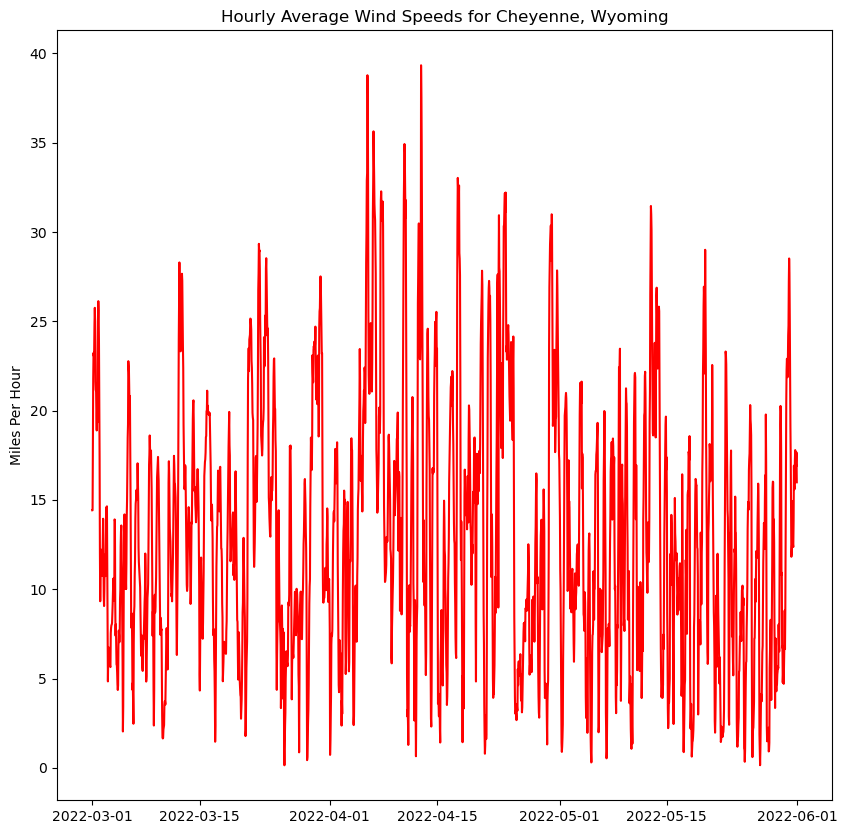

In [112]:
figure = plot_winds(u_values, v_values, ds_u.time)

plt.show()

### Case 2: Opening Many Files or Low CPU Availability

Using Dask to open and extract datasets is a convenient way to speed up the process.   On shared computing systems with PBS job schedulers such as NCAR's Casper cluster, Dask workers can be allocated using separated, dedicated CPU resources.  

In this example, we allocate a Dask cluster with the PBS job scheduler, but it is also possible to allocate Dask clusters using dask_gateway or dask_localcluster, if your system has been configured to allow it.

In [87]:
def get_pbs_cluster():
    """ Create cluster through dask_jobqueue.   
    """
    from dask_jobqueue import PBSCluster
    
    num_jobs = 4
    walltime = '0:15:00'
    memory = '1GB' 

    cluster = PBSCluster(cores=1, processes=1, walltime=walltime, memory=memory, queue='casper', 
                         resource_spec=f"select=1:ncpus=1:mem={memory}",)
    cluster.scale(jobs=num_jobs)
    return cluster

In [120]:
cluster = get_pbs_cluster()

# Connect to cluster
from distributed import Client
client = Client(cluster)

min_workers = 2
client.wait_for_workers(min_workers)

# Display cluster dashboard URL
cluster

/glade/work/bonnland/miniconda3/envs/explore-siphon/lib/python3.12/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 38391 instead
  warnings.warn(


PBSCluster(11377a29, 'tcp://128.117.208.112:43057', workers=2, threads=2, memory=1.86 GiB)

Here, we construct xarray datasets with the data available for the entire year of 2021 and 2022.  It is enough data that without Dask, you are almost surely going to wait a long time to load all of it.  Note that opening the datasets may be relatively quick, but just before plotting, the data actually gets loaded into memory, and the slowdown can be seen then.

Luckily, Dask can speed up the work in a way that scales nearly linearly with the number of workers in the Dask cluster.  In other words, if your cluster has 5 workers, the data should load 5 times as quickly.

In [131]:
# This subdirectory contains surface analysis data on a 0.25 degree global grid
data_dir = '/glade/campaign/collections/rda/data/ds633.0/e5.oper.an.sfc/'

# This bash-style pattern will match data for 2021 and 2022.
year_month_pattern = '202{1,2}*/'

data_dir = data_dir + year_month_pattern

# These filename patterns refer to u- and v-components of winds at 10 meters above the land surface.
filename_pattern_u = 'e5.oper.an.sfc.228_131_u10n.ll025sc.*'
filename_pattern_v = 'e5.oper.an.sfc.228_132_v10n.ll025sc.*'

# Select NetCDF data files
filename_extension = '.nc'

ds_u = get_dataset(data_dir + filename_pattern_u, filename_extension, parallel=True)
ds_v = get_dataset(data_dir + filename_pattern_v, filename_extension, parallel=True)

In [132]:
# We can see the structure of the dataset, even though the values have not been loaded yet.
ds_v 

<xarray.Dataset>
Dimensions:    (time: 17520, latitude: 721, longitude: 1440)
Coordinates:
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * time       (time) datetime64[ns] 2021-01-01 ... 2022-12-31T23:00:00
Data variables:
    V10N       (time, latitude, longitude) float32 dask.array<chunksize=(27, 139, 277), meta=np.ndarray>
    utc_date   (time) int32 dask.array<chunksize=(744,), meta=np.ndarray>
Attributes:
    DATA_SOURCE:          ECMWF: https://cds.climate.copernicus.eu, Copernicu...
    NETCDF_CONVERSION:    CISL RDA: Conversion from ECMWF GRIB1 data to netCDF4.
    NETCDF_VERSION:       4.7.4
    CONVERSION_PLATFORM:  Linux r1i4n6 4.12.14-95.51-default #1 SMP Fri Apr 1...
    CONVERSION_DATE:      Fri Apr  2 16:34:16 MDT 2021
    Conventions:          CF-1.6
    NETCDF_COMPRESSION:   NCO: Precision-preserving compression to netCDF4/HD...
    history:              Fri Apr  2 16:34:33 2021: ncks -4 --ppc default=7 e...
    NCO:                  netCDF Operators version 4.9.5 (Homepage = http://n...

In [109]:
# Select data for a specific geographic location (Cheyenne, Wyoming).
# Note that dataset longitude values are in the range [0, 360].

cheyenne = {'lat': 41.14, 'lon': 360 - 104.82}
boulder =  {'lat': 40.01, 'lon': 360 - 105.27}

city = cheyenne

# Select the nearest grid cell to our lat/lon location.
u = ds_u['U10N'].sel(latitude = city['lat'], longitude= city['lon'], method='nearest')
v = ds_v['V10N'].sel(latitude = city['lat'], longitude= city['lon'], method='nearest')

In [134]:
%%time 

# Actually load the data into memory.
u_values = u.values
v_values = v.values


CPU times: user 5.05 s, sys: 466 ms, total: 5.51 s
Wall time: 28.2 s


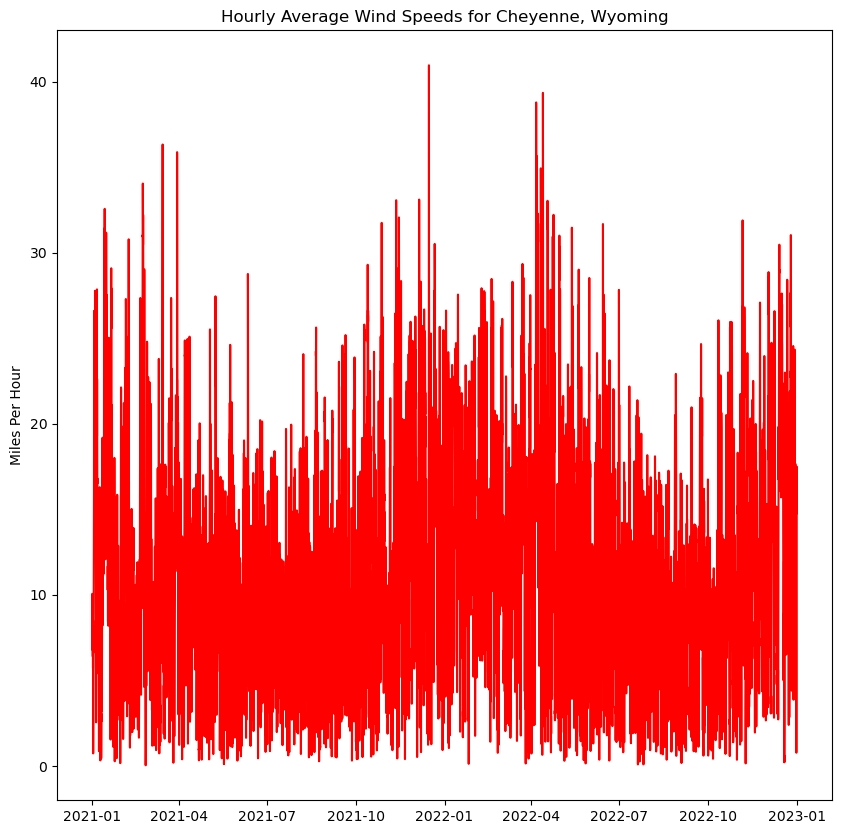

In [135]:
figure = plot_winds(u_values, v_values, ds_u.time)

plt.show()

## Stratus Object Store

# Scratch Area

In [51]:
file_list

['/glade/campaign/collections/rda/data/ds633.0/e5.oper.an.sfc/202203/e5.oper.an.sfc.228_131_u10n.ll025sc.2022030100_2022033123.nc',
 '/glade/campaign/collections/rda/data/ds633.0/e5.oper.an.sfc/202204/e5.oper.an.sfc.228_131_u10n.ll025sc.2022040100_2022043023.nc',
 '/glade/campaign/collections/rda/data/ds633.0/e5.oper.an.sfc/202205/e5.oper.an.sfc.228_131_u10n.ll025sc.2022050100_2022053123.nc',
 '']

In [ ]:
# Show just the file names instead of the full paths
file_names_u = [os.path.split(path)[1] for path in file_list_u]
pprint.pprint(sorted(file_names_u))

In [ ]:
# Show just the file names instead of the full paths
file_names_v = [os.path.split(path)[1] for path in file_list_v]
pprint.pprint(sorted(file_names_v))

In [ ]:
%%time
# This operation opens all 30 data variables and takes ~ 34 minutes for 2007-2023 data
#filespec = file_dir + '/*.grib2'
#ds = xr.open_mfdataset(filespec, engine='cfgrib', combine='nested', concat_dim='time',
#                       backend_kwargs={'indexpath':'/tmp/mygrib.{short_hash}.idx', 
#                                       'filter_by_keys': {'typeOfLevel': 'surface'}})filespec = file_dir + '/*.grib2'
ds_u = xr.open_mfdataset(file_list_u)
ds_u

In [ ]:
%%time
# This operation opens all 30 data variables and takes ~ 34 minutes for 2007-2023 data
#filespec = file_dir + '/*.grib2'
#ds = xr.open_mfdataset(filespec, engine='cfgrib', combine='nested', concat_dim='time',
#                       backend_kwargs={'indexpath':'/tmp/mygrib.{short_hash}.idx', 
#                                       'filter_by_keys': {'typeOfLevel': 'surface'}})filespec = file_dir + '/*.grib2'
ds_v = xr.open_mfdataset(file_list_v)
ds_v

In [ ]:
# Select the surface level (1000 millibar pressure level)
u = ds_u['U'].sel(level=1000, latitude = 40, longitude= 360-105)
v = ds_v['V'].sel(level=1000, latitude = 40, longitude= 360-105)
v

Even though we are extracting less than 1000 values per variable, it can still take a while to open all the data files and extract data, especially on NCAR's jupyterhub system when it is under load.

The following commands actually load the data into memory, as xarray uses a "lazy loading" approach:

In [114]:
%%time 
u_values = u.values
v_values = v.values
winds = wind_speed(u_values, v_values)

TypeError: wind_speed() missing 1 required positional argument: 'units'

In [ ]:
%%time
# This operation considers only temperature 
ds = xr.open_mfdataset(data_files, engine='cfgrib', combine='nested', concat_dim='time',
                       backend_kwargs={'indexpath':'/tmp/mygrib.{short_hash}.idx', 
                                       'filter_by_keys': {'typeOfLevel': 'surface', 'cfVarName': 't'}})

### See if it takes less than 17 minutes using 8 Dask Workers

In [ ]:
%%time
# This operation considers only temperature 
ds = xr.open_mfdataset(data_files, engine='cfgrib', combine='nested', concat_dim='time',
                       parallel=True,
                       backend_kwargs={'indexpath':'/tmp/mygrib.{short_hash}.idx', 
                                       'filter_by_keys': {'typeOfLevel': 'surface', 'cfVarName': 't'}})

In [ ]:
ds

In [ ]:
lon_val = 360-105
ts=ds['t'].sel(latitude=40, longitude=lon_val)
ts.plot()

In [ ]:
ds.to_netcdf('./test_output.nc')

In [22]:
%%time
if USE_GRIB:
    ds_u = xr.open_mfdataset(file_list_u, engine='cfgrib', parallel=True)
    ds_v = xr.open_mfdataset(file_list_v, engine='cfgrib', parallel=True)
else:
    # 5 minutes to extract values
    #ds_u = xr.open_mfdataset(file_list_u, parallel=True)
    #ds_v = xr.open_mfdataset(file_list_v, parallel=True)
    # >>5 minutes to extract values
    #ds_u = xr.open_mfdataset(file_list_u, parallel=True, chunks={'time': -1, 'latitude': 20, 'longitude': 20})
    #ds_v = xr.open_mfdataset(file_list_v, parallel=True, chunks={'time': -1, 'latitude': 20, 'longitude': 20})
    ds_u = xr.open_mfdataset(file_list_u, parallel=True, concat_dim="time", combine="nested",
                  data_vars='minimal', coords='minimal', compat='override')
    ds_v = xr.open_mfdataset(file_list_v, parallel=True, concat_dim="time", combine="nested",
                  data_vars='minimal', coords='minimal', compat='override')


CPU times: user 323 ms, sys: 52.5 ms, total: 375 ms
Wall time: 4.01 s


In [23]:
if USE_GRIB:
    u = ds_u['u'].sel(isobaricInhPa=1000, latitude = 40, longitude= 360-105)
    v = ds_v['v'].sel(isobaricInhPa=1000, latitude = 40, longitude= 360-105)
else:
    u = ds_u['U'].sel(level=1000, latitude = 40, longitude= 360-105)
    v = ds_v['V'].sel(level=1000, latitude = 40, longitude= 360-105)